In [1]:
## Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import os, ast, alive_progress
from alive_progress import alive_bar

from varghadelaney import VD_A as vda
from varghadelaney import VD_A_DF as vdadf

# set inline print
%matplotlib inline

def apfd(nqueries: list, hypsize: list, max_nqueries=None):
    hs = hypsize
    nq = nqueries
    assert hs[0] == 1
    assert len(nq) == len(hs)
    
    extra_nqueries, extra_hs = [],[]
    if(not max_nqueries is None): 
        extra_nqueries = [max_nqueries]
        extra_hs = [hs[-1]]

    return 1 - (np.sum(np.multiply([*nq,*extra_nqueries], np.diff([0, *hs,*extra_hs]))) / (np.max([*nq,*extra_nqueries]) * np.max(hs))) + (1.0 / (2 * np.max([*nq,*extra_nqueries])))

def auc_learning(nqueries: list, hypsize: list, max_nqueries=None):
    hs = hypsize
    nq = nqueries
    assert hs[0] == 1
    assert len(nq) == len(hs)
    
    extra_nqueries, extra_hs = [],[]
    if(not max_nqueries is None): 
        extra_nqueries = [max_nqueries]
        extra_hs = [hs[-1]]
    
    return np.trapz([*hs,*extra_hs],[*nq,*extra_nqueries])

def derive_data(data_frame: pd.DataFrame.dtypes):
    # first, copy dataframe
    df = data_frame.copy()
    
    # ... split queries/symbols into different columns
    for qtype in ["Learning", "Testing"]:
        _lst= df[f"{qtype} queries/symbols"].apply(lambda x: [i.split('/') for i in ast.literal_eval(x)])
        df[f"{qtype} queries"]            = _lst.apply(lambda x : np.cumsum([int(i[0]) for i in x])) # resets
        df[f"{qtype} symbols"]            = _lst.apply(lambda x : np.cumsum([int(i[1]) for i in x])) # symbols w/o resets

    # ... and then parsing string with hypotheses sizes as array of integers
    df["HypSize"] = df["HypSize"].apply(lambda x: ast.literal_eval(x)) 
    df["TQ [Symbols]"] = df["EQ [Symbols]"]+df["MQ [Symbols]"]
    df["TQ [Resets]"] = df["EQ [Resets]"]+df["MQ [Resets]"]

    # ... and then append qSize to HypSize, if the run is successfull 
    df["HypSize"] = df.apply(lambda x: x.HypSize + [x.Qsize] if x.Equivalent=='OK' and len(x.HypSize) < x.Rounds else x.HypSize, axis=1)
    
    # ... and then include #EQs from the single-state model
    df["Testing queries"] = df["Testing queries"].apply(lambda x: [0,*x])
    df["Testing symbols"] = df["Testing symbols"].apply(lambda x: [0,*x])
    
    # ... and then calculate the total number of queries
    df["Total queries"] = df.apply(lambda x: np.add(x["Testing queries"],x["Learning queries"]) if x.Equivalent=='OK' else [], axis=1)
    df["Total symbols"] = df.apply(lambda x: np.add(x["Testing symbols"],x["Learning symbols"]) if x.Equivalent=='OK' else [], axis=1)
    
    # ... and then (FINALLY!) calculate the APFD and AUC for EQs, and TQs
    df_eq = df.query('`Equivalent`=="OK"')
    
    the_cols = ["SUL name","Seed","TQ [Symbols]","EQ [Symbols]"]
    max_eqs = df[the_cols].groupby(["SUL name","Seed"]).max().to_dict()

    #df["APFD_testing"] = df.apply(lambda x: apfd(x['Testing symbols'],x['HypSize']) if x.Equivalent=='OK' else -1, axis=1)
    #df["APFD_total"] = df.apply(lambda x: apfd(x['Total symbols'],x['HypSize']) if x.Equivalent=='OK' else -1, axis=1)
    
    #df["APFDx_testing"] = df.apply(lambda x: apfd(x['Testing symbols'],x['HypSize'],max_nqueries=max_eqs['EQ [Symbols]'][(x['SUL name'],x['Seed'])]) if x.Equivalent=='OK' else -1, axis=1)
    df["APFDx"] = df.apply(lambda x: apfd(x['Total symbols'],x['HypSize'],max_nqueries=max_eqs['TQ [Symbols]'][(x['SUL name'],x['Seed'])]) if x.Equivalent=='OK' else -1, axis=1)
    
    #df["AUC_testing"] = df.apply(lambda x: auc_learning(x['Testing symbols'],x['HypSize'],max_nqueries=max_eqs['EQ [Symbols]'][x['SUL name']]) if x.Equivalent=='OK' else -1, axis=1)
    #df["AUC_total"] = df.apply(lambda x: auc_learning(x['Total symbols'],x['HypSize'],max_nqueries=max_eqs['TQ [Symbols]'][x['SUL name']]) if x.Equivalent=='OK' else -1, axis=1)
    
    # to close, return the new dataframe with derived columns
    return df

def _interp_addsorted(alist, datapoints=[]):
    cc_dp = alist.copy()
    for newdp in datapoints:
        if(newdp in cc_dp): continue
        cc_dp = np.insert(cc_dp,np.searchsorted(cc_dp,newdp),newdp)
    return cc_dp

def interp(data: pd.DataFrame.dtypes, col_costs: str, col_hypsizes: str, datapoints=[]):
    df_subset = data.copy()
    df_subset[col_hypsizes+'_withdatapoints']=df_subset[col_hypsizes].apply(lambda x: _interp_addsorted(x,datapoints))
    df_subset[col_costs]=df_subset.apply(lambda x: np.interp(x[col_hypsizes+'_withdatapoints'], x[col_hypsizes], x[col_costs]),axis=1)
    df_subset[col_hypsizes]=df_subset[col_hypsizes+'_withdatapoints']
    df_subset.drop(col_hypsizes+'_withdatapoints',inplace=True,axis=1)
    return df_subset

# Load CSV, calculate APFD and filter Equivalent==OK

In [2]:
df = pd.concat([pd.read_csv(os.path.join(path_log)) 
                for path_log in ["k_1_k_2_hads_hsi_w_wp_fixed.csv", "k_1_k_2_spy_spyh.csv"]
               ])
df = derive_data(df)

df['CTT'] = df['CTT'].str.replace('Soucha','')
df['CTT'] = pd.Categorical(df['CTT'], ["W", "Wp", "Hsi", "HadsInt", "SPY", "SPYH"])

# count values where Equivalent=='NOK'
with pd.option_context('display.max_rows', 400):
    subset = ['Equivalent','Extra States','CTT']
    display(df[[*subset]].groupby(subset)
            .value_counts()
            .to_frame()
            .pivot_table(0,[subset[0],subset[1]],[subset[2]])
           )

df_equiv=df.query(f'`Equivalent`=="OK" and `Extra States`==2').sort_values(by=['APFDx'],ascending=False)


CTT                       W  Wp  Hsi  HadsInt  SPY  SPYH
Equivalent Extra States                                 
NOK        1              7   6    6        6    6     8
           2              0   0    0        0    0     0
OK         1             39  40   40       40   40    38
           2             46  46   46       46   46    46

# Setup the list of SULs to be analyzed

In [3]:
all_qtype = ['Testing symbols'] # alternative
all_runs = df_equiv[['SUL name', 'Seed']].drop_duplicates()
total = len(all_qtype)*len(all_runs)

# Plot %states detected per test case (for all methods)

In [4]:
# define figure size
sns.set(rc={'figure.figsize':(10,5),'figure.dpi':300})

os.makedirs(f'img/fixed_mode/', exist_ok=True)

with alive_bar(total, force_tty=True, title=f'Plotting APFD') as bar:
    for idx,row in all_runs.iterrows():
        # get an entry <SUL, seed>
        sulname,seed = row['SUL name'],row['Seed']
        subj=df_equiv.query(f'`SUL name`=="{sulname}"').copy()
        
        # add percent columns
        subj['HypSizePercent'] = subj['HypSize'].apply(lambda x: x/np.max(x)*100)

        # explode column with % of symbols and hypothesis sizes in the learning process
        subj=subj.explode(['HypSizePercent',*all_qtype])

        for qtype in all_qtype:
            #create line chart
            apfd_plot = sns.lineplot(subj, x=f'{qtype}', y='HypSizePercent',
                                     markers=True, 
                                     style='CTT', hue='CTT',
                                     palette='tab10'
                                    )
            apfd_plot.set(xscale='log')
            locator = ticker.LogLocator()
            locator.MAXTICKS = np.max(subj[f'{qtype}'])
            apfd_plot.xaxis.set_major_locator(locator)

            apfd_plot.yaxis.set_major_locator(ticker.MultipleLocator(10))
            apfd_plot.set_ylim(0,100)
            
            #add plot labels, titles and legends
            plt.xlabel(f'Number of {qtype.title()} (log scale)')
            plt.ylabel('Fraction of the SUL learned')
            plt.title(f'Subject: {sulname}')
            
            #get handles and labels
            handles, labels = plt.gca().get_legend_handles_labels()
            
            #specify order of items in legend from APFDx
            order = subj[['CTT','APFDx']].sort_values(['APFDx'],ascending=False).drop_duplicates().CTT.to_list()
            for idx,ctt in enumerate(order): order[idx]=labels.index(ctt)
            #add legend to plot
            plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
                       title='Testing Technique', loc='lower right', 
                       fontsize='xx-small', title_fontsize='xx-small')
            
            # save line chart
            fig = apfd_plot.get_figure()
            fname=sulname.replace('.dot','')
            fig.savefig(f'img/fixed_mode/cumsum_{fname}_{qtype}_{seed}.jpg')
            fig.clf()
            bar()

Plotting APFD |████████████████████████████████████████| 46/46 [100%] in 17.6s (2.59/s)                                 


<Figure size 3000x1500 with 0 Axes>

# Calculate the effect size of the APFDx

,A,B,estimate,magnitude
0,HadsInt,Hsi,0.2559073724007561,large
1,HadsInt,SPY,0.1973062381852552,large
2,HadsInt,SPYH,0.21337429111531192,large
3,HadsInt,W,0.30812854442344045,medium
4,HadsInt,Wp,0.40879017013232516,small
5,Hsi,SPY,0.3544423440453686,small
6,Hsi,SPYH,0.3799621928166352,small
7,Hsi,W,0.5061436672967864,negligible
8,Hsi,Wp,0.6086956521739131,small
9,SPY,SPYH,0.527882797731569,negligible


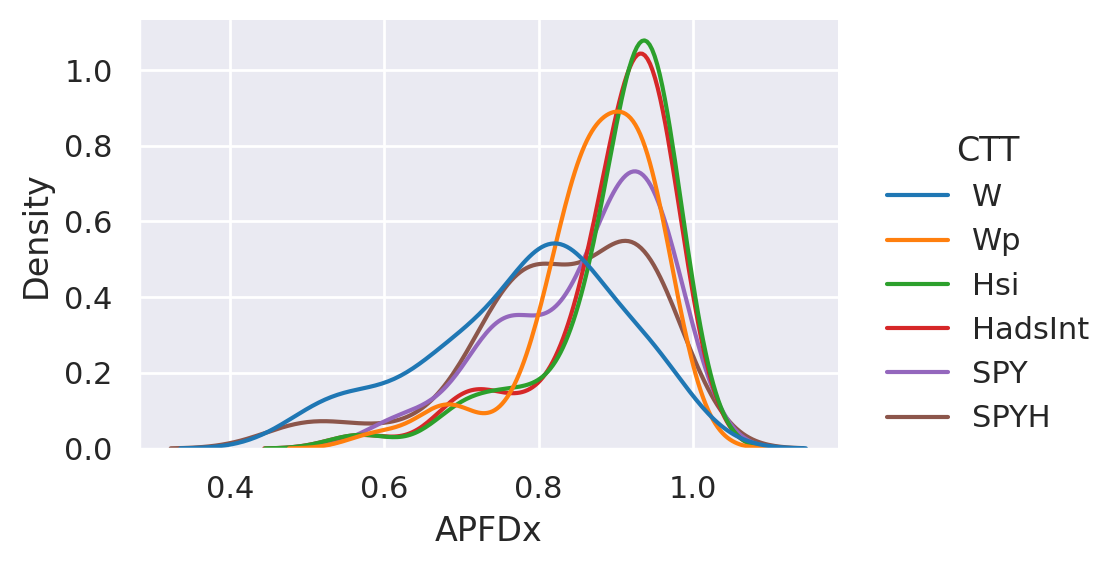

In [5]:
display(vdadf(df_equiv.sort_values(['SUL name','CTT']),'APFDx','CTT'))
p=sns.displot(data=df_equiv, x="APFDx", hue="CTT", kind="kde",palette='tab10', height=3, aspect=1.5)
p.fig.set_dpi(200)
# display(df_equiv.pivot_table('APFDx','SUL name','CTT'))